In [1]:
from PIL import Image, ImageDraw
import argparse
import io

from google.cloud import vision
from google.cloud.vision import types

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import unicodedata                        

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

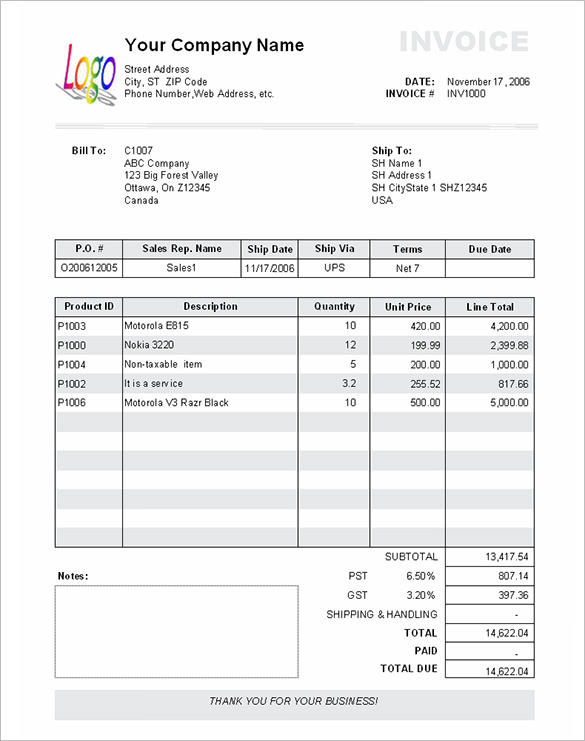

In [2]:
raw_invoice_image_path = 'invoice.jpg'
raw_invoice_image = Image.open(raw_invoice_image_path)
raw_invoice_image

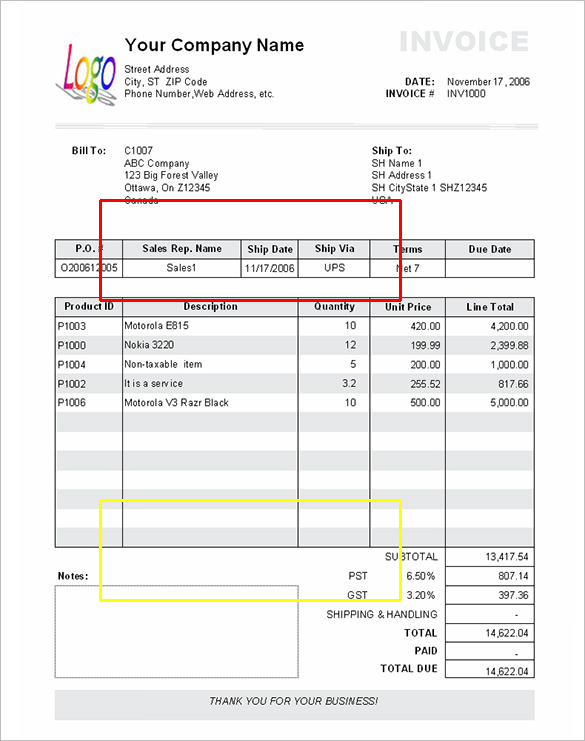

In [3]:
def addRect(draw, point1_X, point1_Y, point2_X, point2_Y,fill, width):
    draw.line((point1_X,point1_Y, point2_X, point1_Y), fill=fill, width=width)
    draw.line((point2_X,point1_Y, point2_X, point2_Y), fill=fill, width=width)
    draw.line((point2_X,point2_Y, point1_X, point2_Y), fill=fill, width=width)
    draw.line((point1_X,point2_Y, point1_X, point1_Y), fill=fill, width=width)

manual_invoice_image = Image.open(raw_invoice_image_path)
draw = ImageDraw.Draw(manual_invoice_image)
addRect(draw, 100,200, 400,300, fill=(255,0,0), width=3)
addRect(draw, 100,500, 400,600, fill=(255,255,0), width=3)
manual_invoice_image

In [4]:
def google_detect_document(path):
    """Detects document features in an image."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)

    response = client.document_text_detection(image=image)
    document = response.full_text_annotation

    for page in document.pages:
        for block in page.blocks:
            block_words = []
            for paragraph in block.paragraphs:
                block_words.extend(paragraph.words)

            block_symbols = []
            for word in block_words:
                block_symbols.extend(word.symbols)

            block_text = ''
            for symbol in block_symbols:
                block_text = block_text + symbol.text

#            print('Block Content: {}'.format(block_text))
#            print('Block Bounds:\n {}'.format(block.bounding_box))
    return document

In [5]:
google_detection = google_detect_document(raw_invoice_image_path)


In [6]:
def print_detected(document):
    for page in document.pages:
        for block in page.blocks:
            block_words = []
            for paragraph in block.paragraphs:
                block_words.extend(paragraph.words)

            block_symbols = []
            for word in block_words:
                block_symbols.extend(word.symbols)

            block_text = ''
            for symbol in block_symbols:
                block_text = block_text + symbol.text

            print('Block Content: {}'.format(block_text))
            print('Block Bounds:\n {}'.format(block.bounding_box))

print_detected(google_detection)

Block Content: YourCompanyName
Block Bounds:
 vertices {
  x: 127
  y: 37
}
vertices {
  x: 302
  y: 37
}
vertices {
  x: 302
  y: 53
}
vertices {
  x: 127
  y: 53
}

Block Content: INVOICE
Block Bounds:
 vertices {
  x: 399
  y: 30
}
vertices {
  x: 530
  y: 30
}
vertices {
  x: 530
  y: 49
}
vertices {
  x: 399
  y: 49
}

Block Content: StreetAddressCity,STZIPCodePhoneNumber,WebAddress,etc
Block Bounds:
 vertices {
  x: 124
  y: 64
}
vertices {
  x: 271
  y: 64
}
vertices {
  x: 271
  y: 98
}
vertices {
  x: 124
  y: 98
}

Block Content: DATE:November17,2006INVOICE#INV1000
Block Bounds:
 vertices {
  x: 386
  y: 75
}
vertices {
  x: 528
  y: 75
}
vertices {
  x: 528
  y: 96
}
vertices {
  x: 386
  y: 96
}

Block Content: BillTo:C1007ABCCompany123BigForestValleyOttawa,OnZ12345Canada
Block Bounds:
 vertices {
  x: 73
  y: 144
}
vertices {
  x: 216
  y: 144
}
vertices {
  x: 216
  y: 203
}
vertices {
  x: 73
  y: 203
}

Block Content: ShipTo:SHName1SHAddress1SHCityState1SHZ12345USA
Bloc

In [7]:
def collect_text_areas(document):
    areas = []
    for page in document.pages:
        for block in page.blocks:
            block_words = []
            for paragraph in block.paragraphs:
                block_words.extend(paragraph.words)

            block_symbols = []
            for word in block_words:
                block_symbols.extend(word.symbols)

            block_text = ''
            for symbol in block_symbols:
                block_text = block_text + symbol.text

            area = {}
            area['text'] = block_text
            area['bounds'] = block.bounding_box
            areas.append(area)
    return areas

text_areas = collect_text_areas(google_detection)
text_areas[0]
    

{'bounds': vertices {
   x: 127
   y: 37
 }
 vertices {
   x: 302
   y: 37
 }
 vertices {
   x: 302
   y: 53
 }
 vertices {
   x: 127
   y: 53
 }, 'text': u'YourCompanyName'}

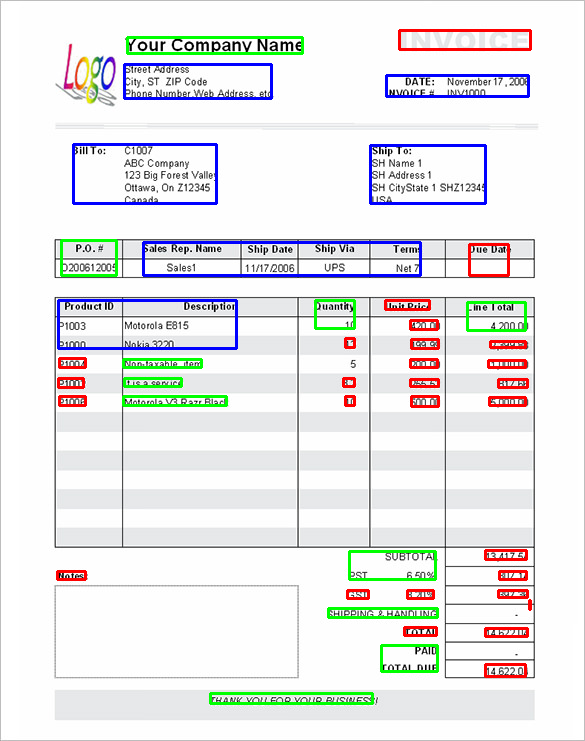

In [8]:
def drawBoxes(path, areas):
    low_threshold_len = 10
    high_threshold_len = 30
    color_low = (255,0,0)
    color_med = (0,255,0)
    color_high = (0,0,255)
    
    count_low=0
    count_med=0
    count_high=0
    
    image = Image.open(path)
    draw = ImageDraw.Draw(image)
    
    for area in areas:

        text = area['text']
        if len(text) < low_threshold_len:
            color=color_low
            count_low+=1
        elif len(text) > high_threshold_len:
            color=color_high
            count_high+=1
        else:
            color=color_med
            count_med+=1
        
        point1_X = area['bounds'].vertices[0].x
        point1_Y = area['bounds'].vertices[0].y
        point2_X = area['bounds'].vertices[2].x
        point2_Y = area['bounds'].vertices[2].y
        addRect(draw, point1_X, point1_Y, point2_X,point2_Y, fill=color, width=3)
    return image, count_low, count_med, count_high
    
image, count_low, count_med, count_high = drawBoxes(raw_invoice_image_path, text_areas)
image

In [9]:
text = google_detection.text
text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
text

'Your Company Name\nINVOICE\nStreet Address\nCity, ST ZIP Code\nPhone Number , Web Address, etc\nDATE : November 17, 2006\nINVOICE #INV1000\nBill To: C1007\nABC Company\n123 Big Forest Valley\nOttawa, On Z12345\nCanada\nShip To:\nSH Name 1\nSH Address 1\nSH City State 1 SHZ12345\nUSA\nP.0.\no20081200s\nSales Rep. Name Ship Date Ship Via Terms\nSales11117 2006 UPS 7 Net\nDue Date\nO\nUnit Price\nProduct ID Description\nP1003 Motorola E815\nP1000 Nokia 3220\nQuantity\n10\nLine Total\n4,200.00\n420.00\n12\n199.99\n2399.88\nP1004\nNon-taxable item\n200.00\n100000\nP1002\nIt is a service\n3.2\n255.52\n817.66\nP1006\nMotorola VS Razr Black\n10\n500.00\n500000\n13,417.54\nSUBTOTAL\nPST 6.50%\nNotes:\n807.14\nGST\n3.20%\n397.36\nH\nSHIPPING & HANDLING\nTOTAL\n14,622.04\nPAID\nTOTAL DUE\n14 ,622.04\nTHANK YOU FOR YOUR BUSINESS\n'

In [10]:
tokens = nltk.word_tokenize(text)
total_len = len(tokens)
tokens

['Your',
 'Company',
 'Name',
 'INVOICE',
 'Street',
 'Address',
 'City',
 ',',
 'ST',
 'ZIP',
 'Code',
 'Phone',
 'Number',
 ',',
 'Web',
 'Address',
 ',',
 'etc',
 'DATE',
 ':',
 'November',
 '17',
 ',',
 '2006',
 'INVOICE',
 '#',
 'INV1000',
 'Bill',
 'To',
 ':',
 'C1007',
 'ABC',
 'Company',
 '123',
 'Big',
 'Forest',
 'Valley',
 'Ottawa',
 ',',
 'On',
 'Z12345',
 'Canada',
 'Ship',
 'To',
 ':',
 'SH',
 'Name',
 '1',
 'SH',
 'Address',
 '1',
 'SH',
 'City',
 'State',
 '1',
 'SHZ12345',
 'USA',
 'P.0',
 '.',
 'o20081200s',
 'Sales',
 'Rep.',
 'Name',
 'Ship',
 'Date',
 'Ship',
 'Via',
 'Terms',
 'Sales11117',
 '2006',
 'UPS',
 '7',
 'Net',
 'Due',
 'Date',
 'O',
 'Unit',
 'Price',
 'Product',
 'ID',
 'Description',
 'P1003',
 'Motorola',
 'E815',
 'P1000',
 'Nokia',
 '3220',
 'Quantity',
 '10',
 'Line',
 'Total',
 '4,200.00',
 '420.00',
 '12',
 '199.99',
 '2399.88',
 'P1004',
 'Non-taxable',
 'item',
 '200.00',
 '100000',
 'P1002',
 'It',
 'is',
 'a',
 'service',
 '3.2',
 '255.52',


In [11]:
#tokenize with regular expression that removes symbols
def tokenize_alpha_num(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    return tokens                            
                                
#remove stopwords
def remove_stop_words(tokens):
    filteredTokens=[]
    swords = set(stopwords.words('english'))
    for t in tokens:
        if t not in swords:
            filteredTokens.append(t)
    return filteredTokens

#remove tokens below n characters
def remove_short_words(tokens, min):
    filteredTokens = []
    for t in tokens:
        if len(t) >= min:
            filteredTokens.append(t)
    return filteredTokens

#remove numbers
def remove_digits(tokens):
    filteredTokens = []
    for t in tokens:
        if not t.isdigit():
            filteredTokens.append(t)
    return filteredTokens

def count_digits(tokens):
    count=0
    for t in tokens:
        if not t.isdigit():
            count+=1
    return count



tokens = tokenize_alpha_num(text)
tokens = remove_stop_words(tokens)

numbers = count_digits(tokens)

tokens = remove_short_words(tokens, 3)

tokens


['Your',
 'Company',
 'Name',
 'INVOICE',
 'Street',
 'Address',
 'City',
 'ZIP',
 'Code',
 'Phone',
 'Number',
 'Web',
 'Address',
 'etc',
 'DATE',
 'November',
 '2006',
 'INVOICE',
 'INV1000',
 'Bill',
 'C1007',
 'ABC',
 'Company',
 '123',
 'Big',
 'Forest',
 'Valley',
 'Ottawa',
 'Z12345',
 'Canada',
 'Ship',
 'Name',
 'Address',
 'City',
 'State',
 'SHZ12345',
 'USA',
 'o20081200s',
 'Sales',
 'Rep',
 'Name',
 'Ship',
 'Date',
 'Ship',
 'Via',
 'Terms',
 'Sales11117',
 '2006',
 'UPS',
 'Net',
 'Due',
 'Date',
 'Unit',
 'Price',
 'Product',
 'Description',
 'P1003',
 'Motorola',
 'E815',
 'P1000',
 'Nokia',
 '3220',
 'Quantity',
 'Line',
 'Total',
 '200',
 '420',
 '199',
 '2399',
 'P1004',
 'Non',
 'taxable',
 'item',
 '200',
 '100000',
 'P1002',
 'service',
 '255',
 '817',
 'P1006',
 'Motorola',
 'Razr',
 'Black',
 '500',
 '500000',
 '417',
 'SUBTOTAL',
 'PST',
 'Notes',
 '807',
 'GST',
 '397',
 'SHIPPING',
 'HANDLING',
 'TOTAL',
 '622',
 'PAID',
 'TOTAL',
 'DUE',
 '622',
 'THANK',

In [12]:
def is_product_id(token):
    if len(token)==5 and token[:1]=='P' and token[1:].isdigit():
        return True
    return False

def is_invoice_id(token):
    if len(token)==7 and token[:3]=='INV' and token[3:].isdigit():
        print("INVOICE!",token)
        return True
    #print("not an invoice",token)
    return False

def recognize_my_items(tokens):
    recognized_tokens=[]
    count_prod=0
    count_invoice=0
    for t in tokens:
        if is_product_id(t):
            recognized_tokens.append("PRODUCTID")
            count_prod+=1
        elif is_invoice_id(t):
            print("RECOGNIZED INVOICE!")
            recognized_tokens.append("INVOICEID")
            count_invoice+=1
        else:
            recognized_tokens.append(t)
    return recognized_tokens, count_prod, count_invoice

tokens, count_prod, count_invoice = recognize_my_items(tokens)
tokens#remove numbers

tokens
print(count_invoice)

('INVOICE!', 'INV1000')
RECOGNIZED INVOICE!
1


In [13]:
features = {}
features["product_ids"]=count_prod
features['numbers'] = numbers
features['invoice_ids']=count_invoice
features['dates']=0
features['addresses']=0
features['nouns']=0
features['verbs']=0
features['small_blocks']=count_low
features['med_blocks']=count_med
features['large_blocks']=count_high
features['total_words']=total_len
features

{'addresses': 0,
 'dates': 0,
 'invoice_ids': 1,
 'large_blocks': 6,
 'med_blocks': 11,
 'nouns': 0,
 'numbers': 99,
 'product_ids': 5,
 'small_blocks': 28,
 'total_words': 145,
 'verbs': 0}

In [15]:
dataframe = pd.read_csv("doc_data.csv")
dataframe

,label,product_ids,numbers,invoice_ids,dates,addresses,nouns,verbs,small_blocks,med_blocks,large_blocks,total_words
0,invoice,3,40,1,2,2,17,15,25,9,7,150
1,email,1,0,1,1,0,40,30,3,3,3,450


In [22]:
inputFeatures=dataframe.as_matrix()
labels=dataframe.loc[:,['label']].as_matrix()
labels

inputFeatures=dataframe.drop(['label'],axis=1).as_matrix()
inputFeatures

label,product_ids,numbers,invoice_ids,dates,addresses,nouns,verbs, small_blocks, med_blocks, large_blocks, total_words
invoice,3,40,1,2,2,17,15,25,9,7,150
email,1,0,1,1,0,40,30, 3,3,3, 450

array([[  3,  40,   1,   2,   2,  17,  15,  25,   9,   7, 150],
       [  1,   0,   1,   1,   0,  40,  30,   3,   3,   3, 450]])